In [1]:
from typing import Optional, List

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo

TARGET_VARIABLE = "Concrete compressive strength"


def compute_pca_variance(data: pd.DataFrame, num_components: int) -> List[float]:
    _pca = PCA(n_components=num_components)
    _pca.fit(data)
    return _pca.explained_variance_ratio_ * 100


def plot_principal_component_variance(data: pd.DataFrame, num_components: Optional[int] = None) -> None:
    data = data.drop(columns=[TARGET_VARIABLE])
    norm_data = (data - data.mean()) / data.std()
    num_components = len(data.columns) if num_components is None else num_components

    variance = compute_pca_variance(data, num_components)
    variance_norm = compute_pca_variance(norm_data, num_components)

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=pd.melt(
            pd.DataFrame({
                "Component": range(1, num_components + 1),
                "None": variance,
                "Normalized": variance_norm,
            }),
            id_vars="Component",
            var_name="Data Pre-processing",
            value_name="Variance",
        ),
        x="Component",
        y="Variance",
        hue="Data Pre-processing",
    )

    plt.xlabel("Principal Component", fontsize=14)
    plt.ylabel("Percentage of Variance Explained", fontsize=14)
    plt.title("Percentage of Variance Explained by Principal Components", fontsize=16)

    for patch in ax.patches:
        if patch.get_height() != 0:
            ax.annotate(
                format(patch.get_height(), ".2f"),
                (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                ha="center", va="center", xytext=(0, 10), textcoords="offset points"
            )

    print(f"Total Percentage Variance Explained by {num_components}"
          f"Components (Regular): {sum(variance):.2f} %")
    print(f"Total Percentage Variance Explained by {num_components}"
          f"Components (Normalized): {sum(variance_norm):.2f} %")
    plt.show()


def plot_pca(_components: pd.DataFrame, _target: pd.Series, normalized: bool) -> None:
    _, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(_components[:, 0], _components[:, 1], c=_target, cmap="RdYlGn")
    ax.set_xlabel("Principal Component 1", fontsize=14)
    ax.set_ylabel("Principal Component 2", fontsize=14)
    title = "Scatter Plot of Two Principal Components" + (" (Normalized)" if normalized else "")
    ax.set_title(title, fontsize=16)
    ax.grid(True)

    sm = ScalarMappable(cmap="RdYlGn")
    sm.set_array(_target)
    cbar = plt.colorbar(sm, label=TARGET_VARIABLE, ax=ax)
    cbar.set_label(TARGET_VARIABLE, fontsize=12)
    plt.show()

In [2]:
concrete_compressive_strength = fetch_ucirepo(id=165)
concrete_compressive_strength.variables

,name,role,type,demographic,description,units,missing_values
0,Cement,Feature,Continuous,None,None,kg/m^3,no
1,Blast Furnace Slag,Feature,Integer,None,None,kg/m^3,no
2,Fly Ash,Feature,Continuous,None,None,kg/m^3,no
3,Water,Feature,Continuous,None,None,kg/m^3,no
4,Superplasticizer,Feature,Continuous,None,None,kg/m^3,no
5,Coarse Aggregate,Feature,Continuous,None,None,kg/m^3,no
6,Fine Aggregate,Feature,Continuous,None,None,kg/m^3,no
7,Age,Feature,Integer,None,None,day,no
8,Concrete compressive strength,Target,Continuous,None,None,MPa,no


In [3]:
features = concrete_compressive_strength.data.features
targets = concrete_compressive_strength.data.targets
dataset = pd.concat([features, targets], axis=1)
dataset.describe().round(2)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
count,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00
mean,281.17,73.90,54.19,181.57,6.20,972.92,773.58,45.66,35.82
std,104.51,86.28,64.00,21.35,5.97,77.75,80.18,63.17,16.71
min,102.00,0.00,0.00,121.80,0.00,801.00,594.00,1.00,2.33
25%,192.38,0.00,0.00,164.90,0.00,932.00,730.95,7.00,23.71
50%,272.90,22.00,0.00,185.00,6.40,968.00,779.50,28.00,34.44
75%,350.00,142.95,118.30,192.00,10.20,1029.40,824.00,56.00,46.14
max,540.00,359.40,200.10,247.00,32.20,1145.00,992.60,365.00,82.60


Total Percentage Variance Explained by 8 Components (Regular): 100.00 %
Total Percentage Variance Explained by 8 Components (Normalized): 100.00 %


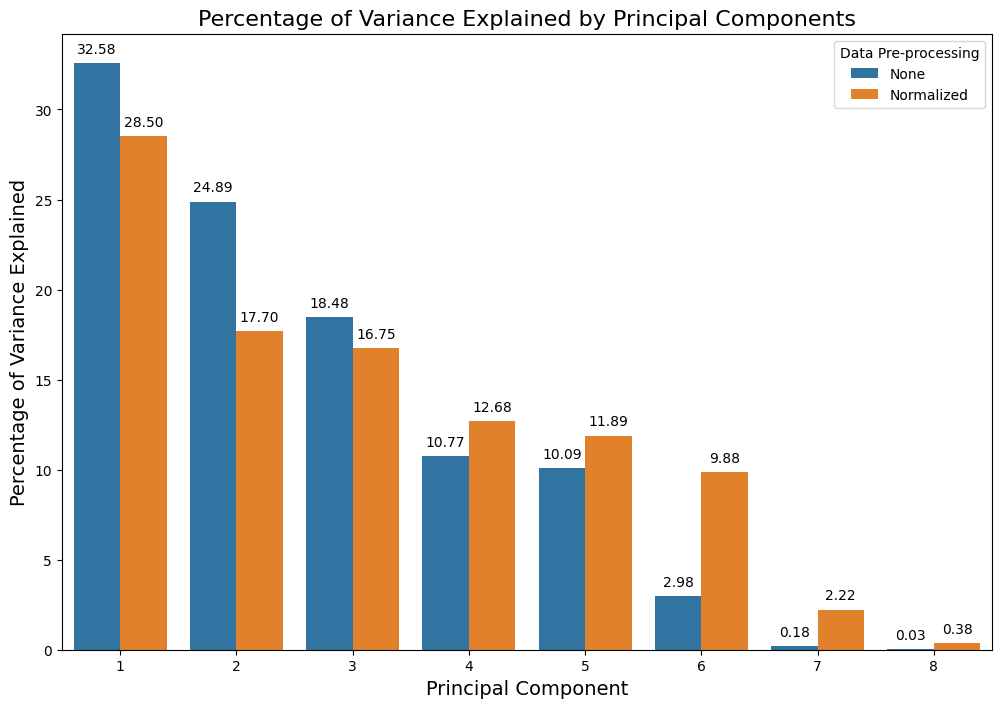

In [4]:
plot_principal_component_variance(dataset)

Total Percentage Variance Explained by 2 Components (Regular): 57.46 %
Total Percentage Variance Explained by 2 Components (Normalized): 46.20 %


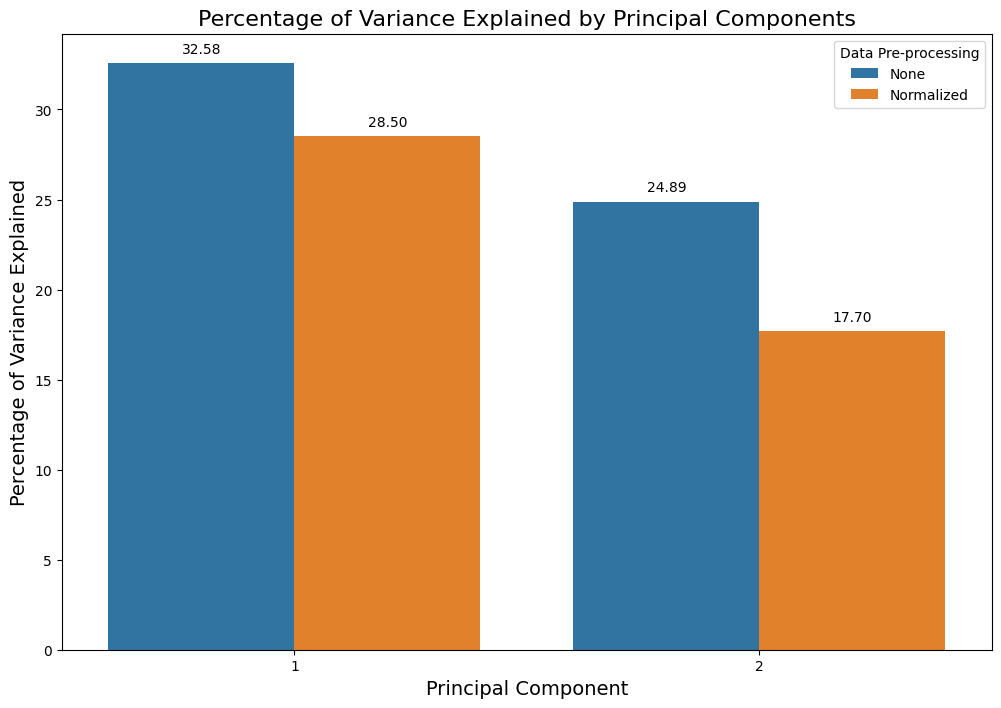

In [5]:
plot_principal_component_variance(dataset, num_components=2)

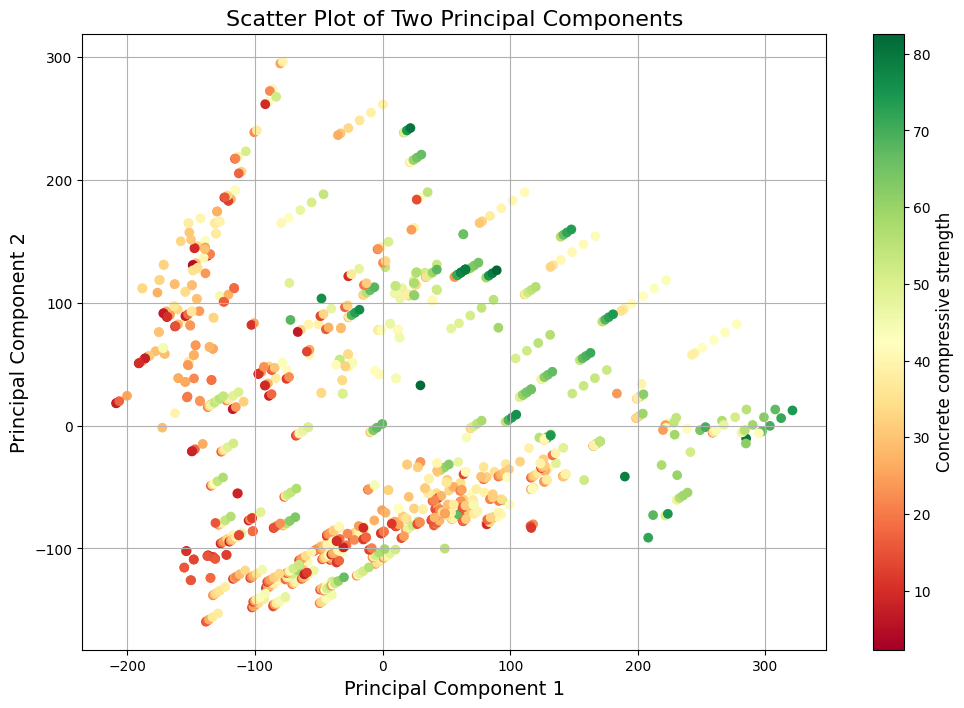

In [6]:
NORMALIZE = False

_dataset = (dataset - dataset.mean()) / dataset.std() if NORMALIZE else dataset

x = _dataset.drop(columns=[TARGET_VARIABLE])
y = _dataset[TARGET_VARIABLE]
pca = PCA(n_components=2)
pca.fit(x)
components = pca.transform(x)
plot_pca(components, y, NORMALIZE)

In [8]:
loadings = abs(pca.components_)
ca = pd.DataFrame({
    "Variable": pca.feature_names_in_,
    "PC1": loadings[0],
    "PC2": loadings[1]
})
ca.sort_values(by="PC1", ascending=False)

,Variable,PC1,PC2
0,Cement,0.905636,0.032661
1,Blast Furnace Slag,0.262578,0.786028
2,Fly Ash,0.238606,0.303039
6,Fine Aggregate,0.210124,0.450725
7,Age,0.098367,0.069862
5,Coarse Aggregate,0.009092,0.274566
3,Water,0.005559,0.076253
4,Superplasticizer,0.001325,0.005110
